In [6]:
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import gensim
from sklearn.base import BaseEstimator, TransformerMixin
import torch
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import pyLDAvis
import pyLDAvis.lda_model
import time
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from gensim.utils import simple_preprocess
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier

[nltk_data] Downloading package stopwords to /Users/bahia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Metriques d'évaluation utilisées
  
  
Perplexity : La perplexité est une mesure de la qualité du modèle. Une perplexité plus faible indique un meilleur modèle. Vous pouvez obtenir ce score en utilisant la méthode perplexity.  
  
Coherence Score : Le score de cohérence mesure la cohérence sémantique des sujets générés par le modèle LDA. Un score de cohérence plus élevé indique que les mots les plus importants d'un sujet sont plus sémantiquement similaires les uns aux autres.  
  
### LDA.  
L'Analyse de la Répartition Latente de Dirichlet (LDA) est une technique de modélisation de sujets qui est largement utilisée en traitement du langage naturel. Elle permet de découvrir les sujets cachés dans un ensemble de documents en attribuant des distributions de probabilité à la fois aux documents (sur les sujets) et aux sujets (sur les mots), ce qui permet d'obtenir une représentation non supervisée et interprétable des données textuelles.



### Lda avec gensim

In [7]:

# Classe de prétraitement
class GensimPreprocessor:
    def __init__(self, stop_words=stopwords.words('english')):
        self.stop_words = stop_words
        
    def tokenize(self, text):
        return [word for word in word_tokenize(text.lower()) if word.isalpha()]
    
    def remove_stopwords(self, tokens):
        return [word for word in tokens if word not in self.stop_words]
    
    def preprocess(self, documents):
        preprocessed = []
        for document in documents:
            tokens = self.tokenize(document)
            tokens = self.remove_stopwords(tokens)
            preprocessed.append(tokens)
        return preprocessed

### Functions

In [8]:
def words_tokenize(text):
  text = text.split()
  return text

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    time_list = []
    for num_topics in range(start, limit, step):
        start_time = time.time()
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        end_time = time.time()
        time_list.append(end_time - start_time)

    return model_list, coherence_values, time_list

def select_top_n_tags(probabilities, threshold, top_n=5):
    # Créer une matrice de zéros de la même forme que probabilities
    final_tags = np.zeros(probabilities.shape)
    
    for i in range(probabilities.shape[0]):
        # Trouver les indices qui satisfont le seuil
        eligible_indices = np.where(probabilities[i] >= threshold)[0]
        
        # Trier ces indices en fonction de leur probabilité
        top_indices = eligible_indices[np.argsort(probabilities[i][eligible_indices])][::-1]
        
        # Sélectionner les top N indices
        top_n_indices = top_indices[:top_n]
        
        # Mettre à 1 les positions correspondant aux tags sélectionnés
        final_tags[i, top_n_indices] = 1
    
    return final_tags

In [9]:
data = pd.read_csv('Data/df_tags_filtered.csv')
data['combined'] = data['Title'] + " " + data['Body']
data['Tags'] = data.Tags.apply(lambda text: words_tokenize(text))
display(data[:1])
X = data['combined'][:2000]
y = data['Tags'][:2000]

,Title,Body,Tags,Body_word_count,combined
0,android jetpack navigation bottomnavigationvie...,android jetpack navigation bottomnavigationvie...,"[android, android-architecture-components, bot...",131,android jetpack navigation bottomnavigationvie...


### nombre optimal de topics

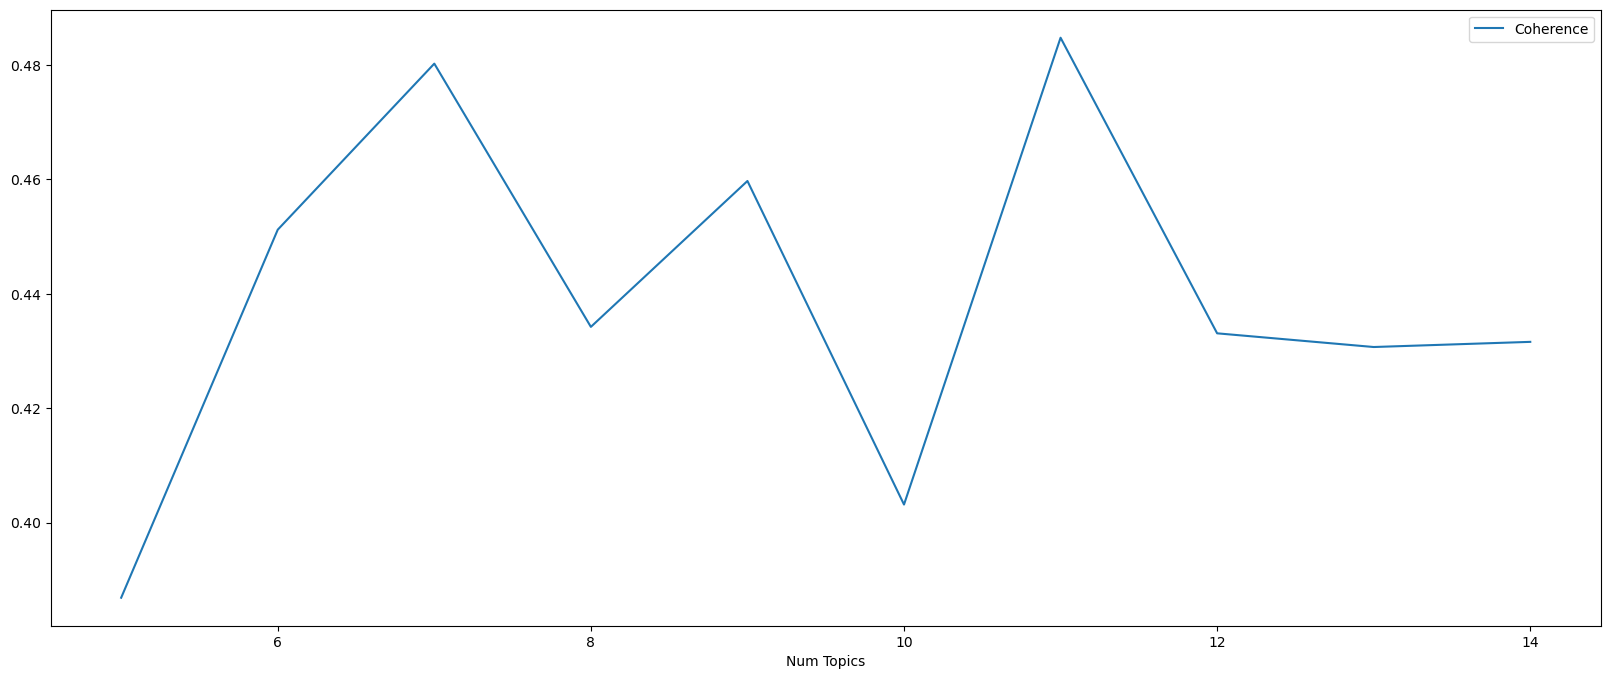

In [10]:
#documents = X_train
documents = X

# Preprocess the text data
preprocessor = GensimPreprocessor()
texts = preprocessor.preprocess(documents)

# Create the Dictionary
dictionary = Dictionary(texts)

# Create the Corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Call the function and plot the results
model_list, coherence_values, time_list = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=5, limit=15, step=1)

x = range(5, 15, 1)
plt.figure(figsize=(20, 8))
plt.plot(x, coherence_values, label='Coherence')
plt.xlabel("Num Topics")
plt.legend(loc='best')
plt.show()

In [11]:
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=6, passes=10)

# for perpelexity
log_perplexity = lda.log_perplexity(corpus)
perplexity = np.exp(-log_perplexity)
print(f"Perplexity on train set: {perplexity}")

# For coherence
coherence_model_lda_train = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score_test = coherence_model_lda_train.get_coherence()
print("Coherence score on train set =", coherence_score_test)


Perplexity on train set: 5026.147742357828
Coherence score on train set = 0.43845870247633484


In [12]:
import pyLDAvis.gensim_models
import pyLDAvis
# Assurez-vous d'appeler pyLDAvis.enable_notebook() dans un environnement Jupyter pour l'interaction inline
pyLDAvis.enable_notebook()

# Préparation des données pour PyLDAVis
vis = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary=dictionary)

# Visualisation
pyLDAvis.display(vis)

In [13]:
# obtain topic distributions for each document
test_documents_topics = lda.get_document_topics(corpus, minimum_probability=0)
topic_dist = pd.DataFrame(test_documents_topics)
for topic in topic_dist.columns:
    topic_dist[topic] = topic_dist[topic].apply(lambda x : x[1])

print('matrix of document/topic distribution shape:', topic_dist.shape)
display(topic_dist.head())


matrix of document/topic distribution shape: (2000, 6)


,0,1,2,3,4,5
0,0.001169,0.687879,0.111078,0.001167,0.001170,0.197537
1,0.002584,0.987076,0.002590,0.002579,0.002580,0.002591
2,0.000820,0.000823,0.995894,0.000821,0.000821,0.000821
3,0.012917,0.012903,0.935515,0.012886,0.012870,0.012910
4,0.003381,0.244145,0.742397,0.003355,0.003359,0.003363


In [14]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2dense
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

preprocessor = GensimPreprocessor()
texts = preprocessor.preprocess(documents)
# Assuming `documents` is your list of posts (already tokenized) and `tags` are the corresponding tags
documents_train, documents_test, tags_train, tags_test = train_test_split(texts, y, test_size=0.2)

# Create a dictionary representation of the documents.
dictionary = Dictionary(documents_train)

# Filter out words that occur in less than 20 documents or more than 50% of the documents.
#dictionary.filter_extremes(no_below=20, no_above=0.5)

# Convert document into the bag-of-words (BoW) format = list of (token_id, token_count).
corpus_train = [dictionary.doc2bow(doc) for doc in documents_train]
corpus_test = [dictionary.doc2bow(doc) for doc in documents_test]

# Train LDA model.
lda = LdaModel(corpus=corpus_train, id2word=dictionary, num_topics=6, passes=10)

# Function to get the topic distribution for documents
def get_document_topics(corpus, model):
    topic_dist = [model.get_document_topics(item) for item in corpus]
    # Convert to dense matrix for sklearn
    num_docs = len(topic_dist)
    num_topics = model.num_topics
    dense = np.zeros((num_docs, num_topics), dtype=float)
    for i, doc in enumerate(topic_dist):
        for topic, prob in doc:
            dense[i, topic] = prob
    return dense

# Get the topic distribution for both training and test sets
doc_topic_dist_train = get_document_topics(corpus_train, lda)
doc_topic_dist_test = get_document_topics(corpus_test, lda)

# Prepare multi-label format
mlb = MultiLabelBinarizer()
tags_train_encoded = mlb.fit_transform(tags_train)
tags_test_encoded = mlb.transform(tags_test)

# Train logistic regression with OneVsRestClassifier
model = OneVsRestClassifier(LogisticRegression())
model.fit(doc_topic_dist_train, tags_train_encoded)

# Predict and evaluate
predictions = model.predict_proba(doc_topic_dist_test)
probabilities = predictions

# Définir un seuil personnalisé pour sélectionner les tags
threshold = 0.15  # baisser le seuil pour inclure plus de tags

# Utiliser la fonction pour obtenir les tags prédits

binary_predictions = select_top_n_tags(probabilities, threshold, top_n=7)
from sklearn.metrics import jaccard_score


print("jaccord score:", jaccard_score(binary_predictions, tags_test_encoded, average='samples'))
print("Precision:", precision_score(binary_predictions, tags_test_encoded, average='samples'))
print("Recall:", recall_score(binary_predictions, tags_test_encoded, average='samples'))
print("F1 Score:", f1_score(binary_predictions, tags_test_encoded, average='samples'))

/Users/bahia/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['a-star', 'abstract-syntax-tree', 'abstractmethoderror', 'accessibility', 'acl', 'activemerchant', 'activitynotfoundexception', 'ad-hoc-distribution', 'ajaxcontroltoolkit', 'amazon-cognito', 'android-4.0.3-ice-cream-sandwich', 'android-api-levels', 'android-bottom-nav-view', 'android-bottomnavigationview', 'android-compose-exposeddropdown', 'android-facebook', 'android-gradle-3.0', 'android-homebutton', 'android-intent-chooser', 'android-jetifier', 'android-keypad', 'android-keystore', 'android-sdk-2.3', 'android-side-navigation', 'android-sms', 'android-studio-import', 'android-togglebutton', 'android-update-sdk', 'anemic-domain-model', 'angular-leaflet-directive', 'angularjs-filter', 'apache-commons-logging', 'apiary.io', 'app-store-connect', 'application-lifecycle', 'article', 'asp.net-webpages', 'asynctaskloader', 'atlassian-sourcetree', 'audio', 'autocomplete

jaccord score: 0.13670833333333332
Precision: 0.14529166666666665
Recall: 0.4433333333333333
F1 Score: 0.21223214285714287


In [15]:
# Afficher les labels des prédictions
predictions_labels = mlb.inverse_transform(binary_predictions)
true_labels = mlb.inverse_transform(tags_test_encoded)
#print(predictions_labels)
#print(true_labels)

In [16]:
# Créer un DataFrame à partir des labels de prédiction et des vrais labels
df = pd.DataFrame({
    'Predicted Labels': predictions_labels,
    'True Labels': true_labels
})

display(df)

,Predicted Labels,True Labels
0,"(android, javascript)","(browser-detection, internet-explorer, javascr..."
1,"(android,)","(command-line, continuous-integration, msbuild..."
2,"(android,)","(exception, java, multithreading, thread-safety)"
3,"(android,)","(c#, entity-framework, entity-framework-core, ..."
4,"(android,)","(android, android-recyclerview, kotlin, materi..."
...,...,...
395,"(android,)","(django, internationalization, localization, p..."
396,"(android,)","(android, android-compatibility, android-suppo..."
397,"(android,)","(c++, constructor, ctor-initializer, initializ..."
398,"(android, android-fragments)","(android, android-6.0-marshmallow, android-dia..."
